In [1]:
import sys
sys.path.append("..") # see os.getcwd()
import time
from quantum_mc.arithmetic.piecewise_linear_transform import PiecewiseLinearTransform3
import numpy as np
from qiskit.test.base import QiskitTestCase
import quantum_mc.calibration.fitting as ft
import quantum_mc.calibration.time_series as ts
from scipy.stats import multivariate_normal, norm
from qiskit.test.base import QiskitTestCase
from qiskit import execute, Aer, QuantumCircuit, QuantumRegister, ClassicalRegister, AncillaRegister
from qiskit.quantum_info import Statevector
#from qiskit_finance.circuit.library import NormalDistribution
from qiskit.circuit.library import NormalDistribution, LogNormalDistribution, IntegerComparator
from qiskit.utils import QuantumInstance
from qiskit.algorithms import IterativeAmplitudeEstimation, EstimationProblem
import matplotlib.pyplot as plt

cm = 1 / 2.54

In [2]:
correl = ft.get_correl("AAPL", "MSFT")
nbits = 3

bounds_std = 3.
num_qubits = [nbits, nbits]        
sigma = correl
bounds = [(-bounds_std, bounds_std), (-bounds_std, bounds_std)] 
mu = [0, 0]

# starting point is a multi-variate normal distribution
normal = NormalDistribution(num_qubits, mu=mu, sigma=sigma, bounds=bounds)

coeff_set = []
xs = []
ys = []
pl_set = []
for ticker in ["MSFT", "AAPL"]:
    ((cdf_x, cdf_y), sigma) = ft.get_cdf_data(ticker)
    (x, y) = ft.get_fit_data(ticker, norm_to_rel = False)
    (pl, coeffs) = ft.fit_piecewise_linear(x, y)
    # scale, to apply an arbitrary delta (we happen to use the same value here, but could be different)
    coeffs = ft.scaled_coeffs(coeffs, 1.0 if ticker == "MSFT" else 1.0)
    coeff_set.append(coeffs)
    xs.append(x)
    ys.append(y)

# calculate the max and min P&Ls
pl_set.append(lambda z : ft.piecewise_linear(z, *coeff_set[0]))
pl_set.append(lambda z : ft.piecewise_linear(z, *coeff_set[1]))
p_max = max(pl_set[0](bounds_std), pl_set[1](bounds_std))
p_min = min(pl_set[0](-bounds_std), pl_set[1](-bounds_std))

# we discretise the transforms and create the circuits
transforms = []
i_to_js = []
i_to_xs = []
j_to_ys = []
for i, ticker in enumerate(["MSFT", "AAPL"]):
    (i_0, i_1, a0, a1, a2, b0, b1, b2, i_to_j, i_to_x, j_to_y) = ft.integer_piecewise_linear_coeffs(coeff_set[i], x_min = -bounds_std, x_max = bounds_std, y_min = p_min, y_max = p_max, nbits_norm=nbits, nbits_extra = 1 if nbits == 2 else 2)
    transforms.append(PiecewiseLinearTransform3(i_0, i_1, a0, a1, a2, b0, b1, b2, nbits = nbits))
    i_to_js.append(np.vectorize(i_to_j))
    i_to_xs.append(np.vectorize(i_to_x))
    j_to_ys.append(np.vectorize(j_to_y))


C:\Users\joemo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:11: DeprecationWarning: `NormalDistribution` is deprecated as of version 0.17.0 and will be removed no earlier than 3 months after the release date. It moved to qiskit_finance.circuit.library.NormalDistribution.
  # This is added back by InteractiveShellApp.init_path()


In [131]:
p_min, p_max

(array(-5.9313367), array(4.30611818))

C:\Users\joemo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:13: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "formt" which is no longer supported as of 3.3 and will become an error two minor releases later
  del sys.path[0]
C:\Users\joemo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:21: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "formt" which is no longer supported as of 3.3 and will become an error two minor releases later


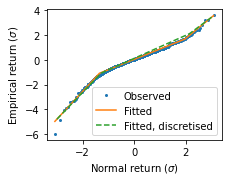

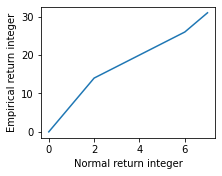

In [4]:
i = np.arange(0, 2**nbits)
index = 0
cm = 1 / 2.54
fig = plt.figure(figsize=(8*cm,6*cm))  
ax = fig.add_axes([0.2, 0.19, 0.77, 0.77])
fig.set_facecolor('w')
ax.plot(xs[index], ys[index], "o", markersize = 2, label = "Observed")
ax.plot(xs[index], np.vectorize(pl_set[index])(xs[index]), label = "Fitted")
ax.plot(i_to_xs[index](i), j_to_ys[index](i_to_js[index](i)), '--', label = "Fitted, discretised")
ax.set_xlabel('Normal return ($\sigma$)')
ax.set_ylabel('Empirical return ($\sigma$)')
ax.legend()
fig.savefig('piecewise_fit.pdf', formt='pdf', facecolor=fig.get_facecolor(), transparent=True)

fig = plt.figure(figsize=(8*cm,6*cm))  
ax = fig.add_axes([0.2, 0.19, 0.77, 0.77])
fig.set_facecolor('w')
ax.plot(i, i_to_js[index](i))
ax.set_xlabel('Normal return integer')
ax.set_ylabel('Empirical return integer')
fig.savefig('piecewise_fit_ints.pdf', formt='pdf', facecolor=fig.get_facecolor(), transparent=True)

C:\Users\joemo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: DeprecationWarning: `NormalDistribution` is deprecated as of version 0.17.0 and will be removed no earlier than 3 months after the release date. It moved to qiskit_finance.circuit.library.NormalDistribution.
  
C:\Users\joemo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:11: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "formt" which is no longer supported as of 3.3 and will become an error two minor releases later
  # This is added back by InteractiveShellApp.init_path()
C:\Users\joemo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:20: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "formt" which is no longer supported as of 3.3 and will become an error two minor releases later


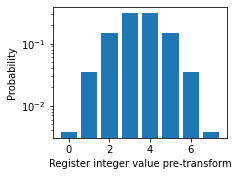

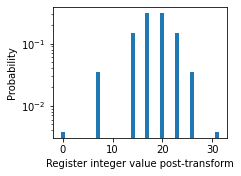

In [27]:
# starting point is a multi-variate normal distribution
single_normal = NormalDistribution(3, mu=0, sigma=1, bounds=(-3, 3) )

fig = plt.figure(figsize=(8*cm,6*cm))  
ax = fig.add_axes([0.2, 0.19, 0.77, 0.77])
fig.set_facecolor('w')
ax.bar(np.arange(0, 2**3), single_normal._probabilities)
ax.set_yscale("log")
ax.set_xlabel('Register integer value pre-transform')
ax.set_ylabel('Probability')
fig.savefig('piecewise_transform_before.pdf', formt='pdf', facecolor=fig.get_facecolor(), transparent=True)

fig = plt.figure(figsize=(8*cm,6*cm))  
ax = fig.add_axes([0.2, 0.19, 0.77, 0.77])
fig.set_facecolor('w')
ax.bar(i_to_js[0](np.arange(0, 2**3)), single_normal._probabilities)
ax.set_yscale("log")
ax.set_xlabel('Register integer value post-transform')
ax.set_ylabel('Probability')
fig.savefig('piecewise_transform_after.pdf', formt='pdf', facecolor=fig.get_facecolor(), transparent=True)

In [ ]:
fig = plt.figure(figsize=(8*cm,6*cm))  
ax = fig.add_axes([0.2, 0.19, 0.77, 0.77])
fig.set_facecolor('w')
plt.plot(xf2, pdf_fn(xf2), label = "Fitted")
ax.hist(rets, density = True, bins = 100, label = "Empirical")
ax.set_xlim(-6, 4)
ax.set_xlabel('Return ($\sigma$)')
ax.set_ylabel('Probability density')
ax.legend()
fig.savefig('hist_pdf_spline_fitted.pdf', format='pdf', facecolor=fig.get_facecolor(), transparent=True)

In [6]:
num_ancillas = transforms[0].num_ancilla_qubits
qr_input = QuantumRegister(nbits * 2, 'input') # 2 times 3 registers
qr_objective = QuantumRegister(1, 'objective')
qr_result = QuantumRegister(nbits * 2, 'result')
qr_ancilla = QuantumRegister(num_ancillas, 'ancilla')
output = ClassicalRegister(nbits * 2, 'output')

state_preparation = QuantumCircuit(qr_input, qr_objective, qr_result, qr_ancilla, output) 
state_preparation.append(normal, qr_input)

for i in range(2):
    offset = i * nbits
    state_preparation.append(transforms[i], qr_input[offset:offset + nbits] + qr_result[:] + qr_ancilla[:])

# to calculate the cdf, we use an additional comparator
x_eval = 5
comparator = IntegerComparator(len(qr_result), x_eval + 1, geq=False)
state_preparation.append(comparator, qr_result[:] + qr_objective[:] + qr_ancilla[0:comparator.num_ancillas])

state_preparation.measure(qr_result, output)

# now check
check = False
if check:
    job = execute(state_preparation, backend=Aer.get_backend('statevector_simulator'))
    var_prob = 0
    for i, a in enumerate(job.result().get_statevector()):
        b = ('{0:0%sb}' % (len(qr_input) + 1)).format(i)[-(len(qr_input) + 1):]
        prob = np.abs(a)**2
        if prob > 1e-6 and b[0] == '1':
            var_prob += prob
    print('Operator CDF(%s)' % x_eval + ' = %.4f' % var_prob)



In [8]:
state_preparation.draw()

┌───────┐┌───────────────────┐                                   »
    input_0: ┤0      ├┤0                  ├───────────────────────────────────»
             │       ││                   │                                   »
    input_1: ┤1      ├┤1                  ├───────────────────────────────────»
             │  P(X) ││                   │┌───────────────────┐              »
    input_2: ┤2      ├┤                   ├┤0                  ├──────────────»
             │       ││                   ││                   │              »
    input_3: ┤3      ├┤                   ├┤1                  ├──────────────»
             └───────┘│                   ││                   │┌──────┐      »
objective_0: ─────────┤                   ├┤                   ├┤4     ├──────»
                      │                   ││                   ││      │┌─┐   »
   result_0: ─────────┤2                  ├┤2                  ├┤0     ├┤M├───»
                      │                   ││                   ││      │└╥┘┌─┐»
   result_1: ─────────┤3                  ├┤3                  ├┤1     ├─╫─┤M├»
                      │                   ││                   ││      │ ║ └╥┘»
   result_2: ─────────┤4                  ├┤4                  ├┤2     ├─╫──╫─»
                      │                   ││                   ││  cmp │ ║  ║ »
   result_3: ─────────┤5                  ├┤5                  ├┤3     ├─╫──╫─»
                      │   pwise_lin_trans ││                   ││      │ ║  ║ »
  ancilla_0: ─────────┤6                  ├┤6                  ├┤5     ├─╫──╫─»
                      │                   ││   pwise_lin_trans ││      │ ║  ║ »
  ancilla_1: ─────────┤7                  ├┤7                  ├┤6     ├─╫──╫─»
                      │                   ││                   ││      │ ║  ║ »
  ancilla_2: ─────────┤8                  ├┤8                  ├┤7     ├─╫──╫─»
                      │                   ││                   │└──────┘ ║  ║ »
  ancilla_3: ─────────┤9                  ├┤9                  ├─────────╫──╫─»
                      │                   ││                   │         ║  ║ »
  ancilla_4: ─────────┤10                 ├┤10                 ├─────────╫──╫─»
                      │                   ││                   │         ║  ║ »
  ancilla_5: ─────────┤11                 ├┤11                 ├─────────╫──╫─»
                      │                   ││                   │         ║  ║ »
  ancilla_6: ─────────┤12                 ├┤12                 ├─────────╫──╫─»
                      │                   ││                   │         ║  ║ »
  ancilla_7: ─────────┤13                 ├┤13                 ├─────────╫──╫─»
                      │                   ││                   │         ║  ║ »
  ancilla_8: ─────────┤14                 ├┤14                 ├─────────╫──╫─»
                      └───────────────────┘└───────────────────┘         ║  ║ »
   output: 4/════════════════════════════════════════════════════════════╩══╩═»
                                                                         0  1 »
«                   
«    input_0: ──────
«                   
«    input_1: ──────
«                   
«    input_2: ──────
«                   
«    input_3: ──────
«                   
«objective_0: ──────
«                   
«   result_0: ──────
«                   
«   result_1: ──────
«             ┌─┐   
«   result_2: ┤M├───
«             └╥┘┌─┐
«   result_3: ─╫─┤M├
«              ║ └╥┘
«  ancilla_0: ─╫──╫─
«              ║  ║ 
«  ancilla_1: ─╫──╫─
«              ║  ║ 
«  ancilla_2: ─╫──╫─
«              ║  ║ 
«  ancilla_3: ─╫──╫─
«              ║  ║ 
«  ancilla_4: ─╫──╫─
«              ║  ║ 
«  ancilla_5: ─╫──╫─
«              ║  ║ 
«  ancilla_6: ─╫──╫─
«              ║  ║ 
«  ancilla_7: ─╫──╫─
«              ║  ║ 
«  ancilla_8: ─╫──╫─
«              ║  ║ 
«   output: 4/═╩══╩═
«              2  3

In [7]:
#state_preparation.draw()
fig = state_preparation.draw(output='mpl')
fig.savefig('../../../outputs/trans_circuit_detail.pdf', format='pdf', facecolor=fig.get_facecolor(), transparent=True, bbox_inches='tight')

<BarContainer object of 34 artists>

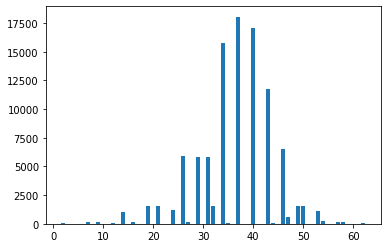

In [7]:
counts = execute(state_preparation, Aer.get_backend('qasm_simulator'), shots = 100000).result().get_counts()
from qiskit.visualization import plot_histogram
plot_histogram(counts, title = "transform of normal")
vals = [int(i, 2) for i,j in counts.items()]
cnts = np.array([j for i,j in counts.items()])

plt.bar(vals, cnts)



No handles with labels found to put in legend.


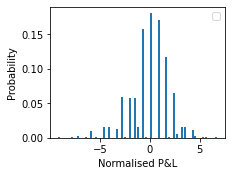

In [8]:
vals2 = p_min * 2 + np.array(vals) * 2 * (p_max - p_min) / (2**(nbits * 2) - 1) 
cnts = np.array([j for i,j in counts.items()])
cnts2 = cnts / np.sum(cnts)

fig = plt.figure(figsize=(8*cm,6*cm))  
ax = fig.add_axes([0.2, 0.19, 0.77, 0.77])
fig.set_facecolor('w')
plt.bar(vals2, cnts2, width = 0.2)
ax.set_xlabel('Normalised P&L')
ax.set_ylabel('Probability')
ax.legend()
fig.savefig('pnl_quantum.pdf', format='pdf', facecolor=fig.get_facecolor(), transparent=True)

In [ ]:
# based on Sascha's noise model

import qiskit.providers.aer.noise as noise
from qiskit.utils import QuantumInstance

# Noise settings
use_noise = True #False
error_scaling_factor = 2 ** 0 # Reference point: 1.0 (= no scaling)
error_prob_1_gate  = 0.001 * error_scaling_factor
error_prob_2_gates = 0.001 * error_scaling_factor
error_prob_measure = 0.001 * error_scaling_factor

error_1 = noise.depolarizing_error(error_prob_1_gate,  1)
error_2 = noise.depolarizing_error(error_prob_2_gates, 2)

# Measurement errors
error_m = noise.pauli_error([('X', error_prob_measure), ('I', 1 - error_prob_measure)])

noise_model = noise.NoiseModel()

noise_model.add_all_qubit_quantum_error(error_1, ['u1', 'u2', 'u3'])
noise_model.add_all_qubit_quantum_error(error_2, ['cx'])
noise_model.add_all_qubit_quantum_error(error_m, "measure")

# Prepare IQAE
backend = Aer.get_backend(simulator)

qinstance = QuantumInstance(backend=backend,
                                seed_simulator=2,
                                seed_transpiler=2,   
                                shots=shots, 
                                noise_model=noise_model)

problem = EstimationProblem(state_preparation=state_preparation, objective_qubits=obj_qubit_ID)
iqae = IterativeAmplitudeEstimation(epsilon_target=epsilon, alpha=alpha, quantum_instance=qinstance)
result = iqae.estimate(problem)



In [ ]:
IBMQ.save_account("543dce4ab356df3a024dfcf606c9d74a31277e39232f0429dacdb0e00daa3622d02865023f613afd659783251eb5bde6f06e9d0f5f1a95b03fdf8a0d34449bef")
provider = IBMQ.load_account()
provider.backends()
backend = provider.get_backend('ibmq_montreal')

In [31]:
from qiskit import IBMQ, transpile
from qiskit import QuantumCircuit
from qiskit.providers.aer import AerSimulator
from qiskit.test.mock import FakeMontreal
device_backend = FakeMontreal() 
sim_be = AerSimulator.from_backend(device_backend)

#sim_ideal = AerSimulator()
#result = sim_ideal.run(transpile(state_preparation, sim_ideal)).result()
#counts = result.get_counts(0)

tcirc = transpile(state_preparation, sim_be)
result_noise = sim_be.run(tcirc).result()
counts_noise = result_noise.get_counts(0)

from qiskit.visualization import plot_histogram
plot_histogram(counts, title = "transform of normal")
vals = [int(i, 2) for i,j in counts.items()]
cnts = [j for i,j in counts.items()]
plt.bar(vals, cnts)

In [5]:
from qiskit import QuantumCircuit, execute
from qiskit import IBMQ, Aer
from qiskit.visualization import plot_histogram
from qiskit.providers.aer.noise import NoiseModel

# Build noise model from backend properties
#provider = IBMQ.load_account()
from qiskit.test.mock import FakeMontreal
backend = FakeMontreal()
#backend = provider.get_backend('ibmq_montreal')
noise_model = NoiseModel.from_backend(backend)

# Get coupling map from backend
coupling_map = backend.configuration().coupling_map

# Get basis gates from noise model
basis_gates = noise_model.basis_gates

counts = execute(state_preparation, Aer.get_backend('qasm_simulator'), 
                #shots = 500000,
                coupling_map=coupling_map,
                basis_gates=basis_gates,
                noise_model=noise_model
                ).result().get_counts()

from qiskit.visualization import plot_histogram
plot_histogram(counts, title = "transform of normal")
vals = [int(i, 2) for i,j in counts.items()]
cnts = [j for i,j in counts.items()]
plt.bar(vals, cnts)


In [5]:
import qiskit.providers.aer.noise as noise
from qiskit.utils import QuantumInstance

print(time.strftime("%H:%M:%S", time.localtime()))

error_scaling_factor = 2 ** 0 # Reference point: 1.0 (= no scaling)
error_prob_1_gate  = 0.001 * error_scaling_factor
error_prob_2_gates = 0.001 * error_scaling_factor
error_prob_measure = 0.001 * error_scaling_factor

error_1 = noise.depolarizing_error(error_prob_1_gate,  1)
error_2 = noise.depolarizing_error(error_prob_2_gates, 2)

# Measurement errors
error_m = noise.pauli_error([('X', error_prob_measure), ('I', 1 - error_prob_measure)])

noise_model = noise.NoiseModel()

noise_model.add_all_qubit_quantum_error(error_1, ['u1', 'u2', 'u3'])
noise_model.add_all_qubit_quantum_error(error_2, ['cx'])
noise_model.add_all_qubit_quantum_error(error_m, "measure")

# now do AE
problem = EstimationProblem(state_preparation=state_preparation,
                    objective_qubits=[len(qr_input)])

# target precision and confidence level
epsilon = 0.01
alpha = 0.05
qi = QuantumInstance(Aer.get_backend('aer_simulator'), noise_model=noise_model)
ae_cdf = IterativeAmplitudeEstimation(epsilon, alpha=alpha, quantum_instance=qi)
result_cdf = ae_cdf.estimate(problem)


conf_int = np.array(result_cdf.confidence_interval)
print('Estimated value:\t%.4f' % result_cdf.estimation)
print('Confidence interval: \t[%.4f, %.4f]' % tuple(conf_int))

#state_preparation.draw()

print(time.strftime("%H:%M:%S", time.localtime()))

22:38:34
Estimated value:	0.1146
Confidence interval: 	[0.1121, 0.1170]
23:08:01


In [18]:
def get_sims(normal_distribution):
    import numpy as np
    values = normal_distribution._values
    probs = normal_distribution._probabilities
    # we generate a bunch of realisation of values, based 
    upper_bounds = [0.0]
    stop = 0.0
    for val, prob in zip(values, probs):
        stop += prob
        upper_bounds.append(stop)
    
    np.random.seed = 101
    r = np.random.uniform(low=0.0, high=1.0, size=1000000)
    indices = np.searchsorted(upper_bounds, r, side='left', sorter=None) - 1

    g1, g2 = np.meshgrid(range(2**nbits), range(2**nbits), indexing="ij",)
    i1 = g1.flatten()[indices]
    i2 = g2.flatten()[indices]
    #x = list(zip(*(grid.flatten() for grid in meshgrid)))
    return i1, i2

i1, i2 = get_sims(normal)
j1 = i_to_js[0](i1)
j2 = i_to_js[1](i2)
j_tot = j1 + j2





<BarContainer object of 37 artists>

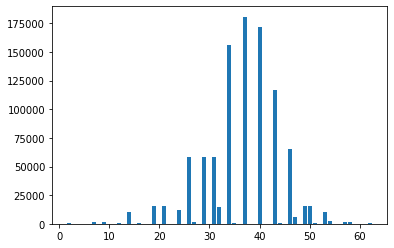

In [19]:
import collections
counts = {}
for item in j_tot:
    if item in counts:
        counts[item] += 1
    else:
        counts[item] = 1

counts = collections.OrderedDict(sorted(counts.items()))

vals = [i for i,j in counts.items()]
cnts = [j for i,j in counts.items()]
plt.bar(vals, cnts)

No handles with labels found to put in legend.


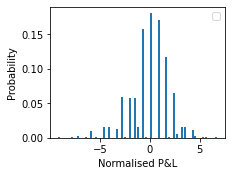

In [9]:
vals2 = p_min * 2 + np.array(vals) * 2 * (p_max - p_min) / (2**(nbits * 2) - 1) 
cnts = np.array([j for i,j in counts.items()])
cnts2 = cnts / np.sum(cnts)

fig = plt.figure(figsize=(8*cm,6*cm))  
ax = fig.add_axes([0.2, 0.19, 0.77, 0.77])
fig.set_facecolor('w')
plt.bar(vals2, cnts2, width = 0.2)
ax.set_xlabel('Normalised P&L')
ax.set_ylabel('Probability')
ax.legend()
fig.savefig('pnl_classical.pdf', format='pdf', facecolor=fig.get_facecolor(), transparent=True)

In [21]:
sum = 0
for v,c in zip(vals, cnts):
    if v <= 8:
        sum += c
print(float(sum) / 1000000)

print(p_min * 2 + 14 * 2 * (p_max - p_min) / (2**(nbits * 2) - 1) )



0.492731
5.80827695826642


In [11]:
correl = ft.get_correl("AAPL", "MSFT")

c = np.linalg.cholesky(correl)
r = np.random.normal(0, 1, size = (2, 1000000))
v = c@r

v1 = np.vectorize(pl_set[0])(v[0, :])
v2 = np.vectorize(pl_set[1])(v[1, :])

vt = v1 + v2

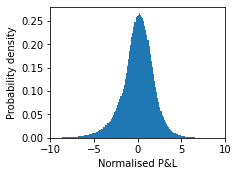

In [12]:
cm = 1 / 2.54
fig = plt.figure(figsize=(8*cm,6*cm))  
ax = fig.add_axes([0.2, 0.19, 0.77, 0.77])
fig.set_facecolor('w')
_ = plt.hist(vt, bins = 200, density = True)
ax.set_xlabel('Normalised P&L')
ax.set_ylabel('Probability density')
ax.set_xlim(-10, 10)
fig.savefig('pnl_classical_continuous.pdf', format='pdf', facecolor=fig.get_facecolor(), transparent=True)

In [150]:
np.percentile(vt, 1.0)

-5.45930852461163

In [20]:
import quantum_mc.calibration.time_series as ts
(cdf_c_x, cdf_c_y) = ts.ecdf(vt)

#(cdf_d_x, cdf_d_y) = ts.ecdf(vt)

sum = 0
cum_sum = []
for v,c in zip(vals, cnts):
    sum += c
    cum_sum.append(sum)
cum_sum = np.array(cum_sum)
cum_sum = cum_sum / np.max(cum_sum)
vals2 = p_min * 2 + np.array(vals) * 2 * (p_max - p_min) / (2**(nbits * 2) - 1)

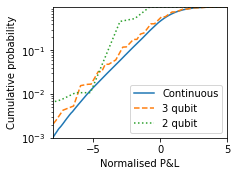

In [22]:
vals_2bits = np.array([-10.70188609, -7.39985348, -6.29917595, -5.19849841, -2.99714334, -1.8964658, -0.79578826, 1.40556681, 2.50624435, 4.70759942])
cum_prob_2bits = np.array([0.003903, 0.007387, 0.010792, 0.010795, 0.462747, 0.537787, 0.98928, 0.992701, 0.996142, 1.])

fig = plt.figure(figsize=(8*cm,6*cm))  
ax = fig.add_axes([0.2, 0.19, 0.77, 0.77])
fig.set_facecolor('w')
plt.plot(cdf_c_x, cdf_c_y, label = "Continuous", )
plt.plot(vals2, cum_sum, '--', label = "3 qubit")
plt.plot(vals_2bits, cum_prob_2bits, ':', label = "2 qubit")
ax.set_yscale("log")
ax.set_xlabel('Normalised P&L')
ax.set_ylabel('Cumulative probability')
ax.set_xlim(-8, 5)
#ax.set_ylim(0.001, 0.02)
ax.set_ylim(0.001, 0.999)
ax.legend()
fig.savefig('cdf_class_quant_log.pdf', format='pdf', facecolor=fig.get_facecolor(), transparent=True)


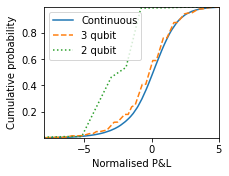

In [23]:
fig = plt.figure(figsize=(8*cm,6*cm))  
ax = fig.add_axes([0.2, 0.19, 0.77, 0.77])
fig.set_facecolor('w')
plt.plot(cdf_c_x, cdf_c_y, label = "Continuous")
plt.plot(vals2, cum_sum, '--', label = "3 qubit")
plt.plot(vals_2bits, cum_prob_2bits, ':', label = "2 qubit")
#ax.set_yscale("log")
ax.set_xlabel('Normalised P&L')
ax.set_ylabel('Cumulative probability')
ax.set_xlim(-8, 5)
#ax.set_ylim(0.001, 0.02)
ax.set_ylim(0.001, 0.999)
ax.legend()
fig.savefig('cdf_class_quant_lin.pdf', format='pdf', facecolor=fig.get_facecolor(), transparent=True)


In [30]:
cont = np.interp([0.01, 0.025, 0.05], cdf_c_y, cdf_c_x)
quant3 = np.interp([0.01, 0.025, 0.05], cum_sum, vals2)
quant2 = np.interp([0.01, 0.025, 0.05], cum_prob_2bits, vals_2bits)
np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})
print('Continuous')
print(cont)
print('3 qubits')
print(quant3)
print(abs(quant3/cont - 1) * 100)
print('2 qubits')
print(quant2)
print(abs(quant2/cont - 1) * 100)

Continuous
[-5.44 -4.21 -3.23]
3 qubits
[-6.22 -4.88 -3.77]
[14.32 15.84 16.60]
2 qubits
[-6.56 -5.13 -5.01]
[20.47 21.81 55.00]


In [ ]:
print("Check")